# Hybrid Monte Carlo

TODO:
 - Kernel density estimation for the sampled values
 - Trajectory animation

In [1]:
%matplotlib inline

import autograd.numpy as np
from autograd import jacobian

from scipy.signal import correlate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tqdm import tqdm_notebook as tqdm

from IPython.display import HTML, Image

In [2]:
def gaussian_potential(mean, cov):
    
    def E(z):
        z_ = (z - mean)
        return 0.5 * np.sum(np.dot(z_, cov) * z_, axis=-1)
    
    return E

In [3]:
def kinetic_energy(scale, size):
    
    def K(r):
        return 0.5 * np.dot(r, r) / (scale**2)
        
    def sample():
        return np.random.normal(loc=0., scale=scale, size=size)
        
    return K, sample

In [4]:
def hamiltonian(E, K):
    
    def H(z, r):
        return E(z) + K(r)
    
    return H

In [5]:
def run_dynamics(r_0, z_0, epsilon, num_steps, dE_dz):
    """
    Leapfrog integration of the dynamics for
    
    time = num_steps * epsilon 
    """
    
    # We accumulate all positions in this list
    zs = [z_0]

    z = z_0
    
    # First momentum update
    r = r_0 - epsilon / 2. * dE_dz(z)
    
    for i in range(num_steps - 1):
        
        # Middle leapfrog steps
        z = z + epsilon * r
        r = r - epsilon * dE_dz(z)
        
        zs.append(z)
     
    # Final leapfrog updates
    z = z + epsilon * r
    r = r - epsilon / 2. * dE_dz(z)
    
    zs.append(z)
    
    return z, r, zs

In [6]:
# Define the E Gaussian
mean = np.array([0, 0]).T
cov = np.array([[1, 0.8], 
                [0.8, 1]])

# Define HMC parameters
mixing_time = 50

num_integral_steps = 10
num_samples = 100 * mixing_time
epsilon = 1e-1

z_0 = np.array([0, 0]).T

simulations = []
accepts = []

samples = []

E = gaussian_potential(mean=mean,
                       cov=cov)
K, sample = kinetic_energy(scale=1., size=z_0.shape)
H = hamiltonian(E, K)

for step in tqdm(range(num_samples)):
    
    # Sample r
    r_0 = sample()
    
    # Sample direction
    sign = np.random.choice([-1, 1])
    
    step_size = sign * epsilon
    
    # Run the system dynamics
    z, r, zs = run_dynamics(r_0, z_0, step_size, num_integral_steps, jacobian(E))
    
    # Metropolis accept/reject step
    threshold = np.minimum(1, np.exp(H(z_0, r_0) - H(z, r)))
    
    u = np.random.uniform(low=0., high=1.)
    
    is_accepted = threshold >= u
    
    if is_accepted:
        z_0 = z
    
    # Append the new sample to the list
    samples.append(z_0)
    
    # Add simulations
    simulations.append(zs)
    accepts.append(is_accepted)
    
# Trim the samples so that we get realtively uncorrelated samples
samples = np.array(samples)[::mixing_time]

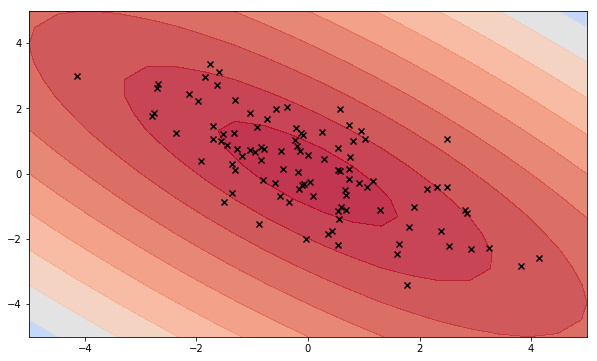

In [7]:
z1 = np.linspace(-5, 5, 20)
z2 = np.linspace(-5, 5, 20)

z1_grid, z2_grid = np.meshgrid(z1, z2)

z_grid = np.stack([z1_grid, z2_grid], axis=-1).reshape(-1, 2)

log_likelihood = -E(z_grid).reshape(20, 20)

# Plot samples on a contour plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(samples[:, 0], samples[:, 1], zorder=2, c='k', marker='x')
ax.contourf(z1_grid, z2_grid, log_likelihood, cmap="coolwarm", levels=-0.5*np.arange(12, -0.1, -1)**2, alpha=0.8)
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])

plt.show()

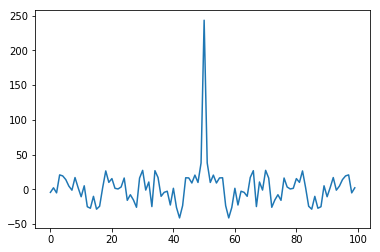

In [8]:
auto_corr = correlate(samples[:, 0], samples[:, 0], mode='same')

fig, ax = plt.subplots()
ax.plot(auto_corr)

plt.show()

In [9]:
def update_plot(num, data, line):
    line.set_data(data[..., :num])
    return line,

fig, ax = plt.subplots(figsize=(10, 6))

zs_1 = np.array(simulations[1:51]).reshape((-1, 2)).T

print(zs_1.shape)

traj, = ax.plot([], [], zorder=2, color='b')
ax.scatter(samples[:2, 0], samples[:2, 1], zorder=3, c='k', marker='x')
ax.contourf(z1_grid, z2_grid, log_likelihood, cmap="coolwarm", levels=-0.5*np.arange(12, -0.1, -1)**2, alpha=0.8)
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])

line_ani = animation.FuncAnimation(fig, update_plot, 700, fargs=(zs_1, traj),
                                   interval=50, blit=True)

line_ani.save("../img/test.gif", writer='imagemagick', fps=30)
plt.close()

(2, 550)


![HybridMonteCarlo](../img/test.gif "HMC")